### Problem Set 5
#### MACS 30150, Dr. Evans
#### Due Wednesday, Feb. 13 at 11:30am
#### Haowen Shang

#### 1. Some income data, lognormal distribution, and GMM.

In [1]:
import numpy as np
import numpy.linalg as lin
import matplotlib.pyplot as plt
import warnings
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import pandas as pd

In [2]:
warnings.filterwarnings("ignore")

#### (a)Plot a histogram of percentages of the income.txt data with 30 bins.

In [3]:
# Load the data as a Pandas dataframe
df = pd.read_csv("data/incomes.txt", names=["income"])

Text(0, 0.5, 'Percent of incomes')

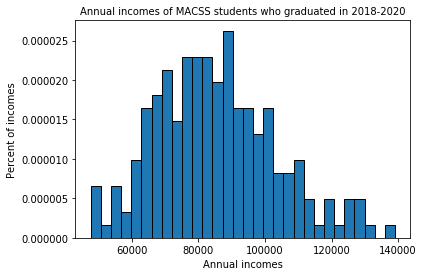

In [4]:
num_bins = 30
plt.hist(df['income'], num_bins, normed=True, edgecolor='k')
plt.title('Annual incomes of MACSS students who graduated in 2018-2020', fontsize=10)
plt.xlabel('Annual incomes')
plt.ylabel('Percent of incomes')

#### (b) Estimate the parameters of the lognormal distribution by generalized method of moments.

In [5]:
def trunc_lognorm_pdf(xvals, mu, sigma, cut_lb, cut_ub):

    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu)) -
                       sts.lognorm.cdf(cut_lb, sigma,scale=np.exp(mu)))
            
    pdf_vals    = ((1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

In [6]:
def data_moments(xvals):
    
    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data

In [7]:
def model_moments(mu, sigma, cut_lb, cut_ub):
   
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)
    
    return mean_model, np.sqrt(var_model)

In [8]:
def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):

    mean_data, var_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [var_data]])
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [9]:
def criterion(params, *args):
    
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub,simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [10]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (df['income'], 0, 150000, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

mu_GMM1= 11.333533482547029  sig_GMM1= 0.21386191435240354


In [11]:
mean_data, std_data = data_moments(df['income'])
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1, 0.0, 150000.0)
err1 = err_vec(df['income'], mu_GMM1, sig_GMM1, 0.0, 150000.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Standard Deviation of points =', std_data)
print('Mean of model =', mean_model, ', Standard Deviation =', std_model)
print('Error vector=', err1)
print('GMM criterion function:',results.fun)

Mean of points = 85276.82360625811 , Standard Deviation of points = 18037.692869371564
Mean of model = 85276.82405894178 , Standard Deviation = 18037.692424756886
Error vector= [ 5.30840212e-09 -2.46491988e-08]
GMM criterion function: [[6.35762135e-16]]


In [12]:
print("the difference between mean of data and mean from model is:",abs(mean_data-mean_model))
print("the difference between standard deviation of data and that from model is:",abs(std_data-std_model))

the difference between mean of data and mean from model is: 0.0004526836710283533
the difference between standard deviation of data and that from model is: 0.00044461467768996954


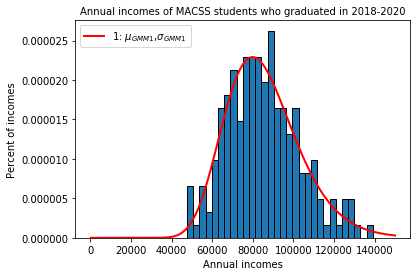

In [13]:
num_bins = 30
plt.hist(df['income'], num_bins, normed=True, edgecolor='k')
plt.title('Annual incomes of MACSS students who graduated in 2018-2020', fontsize=10)
plt.xlabel('Annual incomes')
plt.ylabel('Percent of incomes')

dist_pts = np.linspace(0, 150000, 1000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 150000),
         linewidth=2, color='r', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')

#### (c) Perform the two-step GMM estimator

In [14]:
def get_Err_mat2(pts, mu, sigma, cut_lb, cut_ub, simple=False):
  
    R = 2
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = pts - mean_model
        Err_mat[1, :] = (np.sqrt((mean_data - pts) ** 2)) - std_model
    else:
        Err_mat[0, :] = (pts - mean_model) / mean_model
        Err_mat[1, :] = (np.sqrt((mean_data - pts) ** 2) - std_model) / std_model
    
    return Err_mat

In [15]:
Err_mat = get_Err_mat2(df["income"], mu_GMM1, sig_GMM1, 0, 150000, simple = False)
VCV2 = (1 / df["income"].shape[0]) * (Err_mat @ Err_mat.T)#
print("Omega_2: ",VCV2)
W_hat2 = lin.inv(VCV2)
print("W_hat2: ",W_hat2)

Omega_2:  [[0.04451671 0.0271726 ]
 [0.0271726  0.40492074]]
W_hat2:  [[23.42289977 -1.57181651]
 [-1.57181651  2.57509742]]


In [16]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (df['income'], 0.0, 150000, W_hat2)
results2 = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

mu_GMM2= 11.333533482547029  sig_GMM2= 0.21386191435240354


In [17]:
mean_model2, std_model2 = model_moments(mu_GMM2, sig_GMM2, 0.0, 150000.0)
err2 = err_vec(df['income'], mu_GMM2, sig_GMM2, 0.0, 150000.0, False).reshape(2,)
print('Mean of points =', mean_data, ', Standard Deviation of points =', std_data)
print('Mean of model =', mean_model2, ', Standard Deviation of model =', std_model2)
print('Error vector=', err2)
print('GMM criterion function:',results2.fun)

Mean of points = 85276.82360625811 , Standard Deviation of points = 18037.692869371564
Mean of model = 85276.82405894178 , Standard Deviation of model = 18037.692424756886
Error vector= [ 5.30840212e-09 -2.46491988e-08]
GMM criterion function: [[2.63596008e-15]]


In [18]:
print("the difference between mean of data and mean from model is:",abs(mean_data-mean_model2))
print("the difference between standard deviation of data and that from model is:",abs(std_data-std_model2))

the difference between mean of data and mean from model is: 0.0004526836710283533
the difference between standard deviation of data and that from model is: 0.00044461467768996954


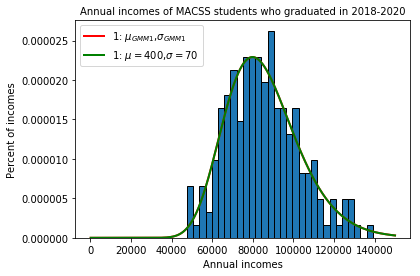

In [19]:
num_bins = 30
plt.hist(df['income'], num_bins, normed=True, edgecolor='k')
plt.title('Annual incomes of MACSS students who graduated in 2018-2020', fontsize=10)
plt.xlabel('Annual incomes')
plt.ylabel('Percent of incomes')

dist_pts = np.linspace(0, 150000, 1000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0.0, 150000),
         linewidth=2, color='r', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')

dist_pts = np.linspace(0, 150000, 1000)
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM2, sig_GMM2, 0.0, 150000),
         linewidth=2, color='g', label='1: $\mu=400$,$\sigma=70$')
plt.legend(loc='upper left')

#### (d) Estimate the lognormal PDF to fit the data by GMM using different moments.

In [20]:
def data_moments3(xvals):
    
    bpct_1_dat = xvals[xvals <75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >= 100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat

In [21]:
def model_moments3(mu, sigma, cut_lb, cut_ub):
   
    xfx = lambda x: trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.0, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

In [22]:
def err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple):
   
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [23]:
def criterion3(params, *args):
    
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err 
    
    return crit_val

In [24]:


def model_moments3(mu, sigma, cut_lb=0.0, cut_ub=150000.0):
    xfx = lambda x: sts.lognorm.pdf(x, scale = np.exp(mu), s=sigma)
    (mom1_model, m_m_err) = intgr.quad(xfx, 0, 75000)
    (mom2_model, m_m_err)= intgr.quad(xfx, 75000, 100000)
    (mom3_model, m_m_err) = intgr.quad(xfx, 100000, np.inf)    
    return mom1_model,mom2_model,mom3_model

def err_vec3(x, mu, sigma, cut_lb, cut_ub, simple):
  
    mom1_data, mom2_data,mom3_data = data_moments3(x)
    mom_data = np.array([[mom1_data], [mom2_data],[mom3_data]])
    mom1_model,mom2_model,mom3_model = model_moments3(mu, sigma, cut_lb, cut_ub)
    mom_model = np.array([[mom1_model],[mom2_model],[mom3_model]])
    
    if simple:
        err_vec = mom_model - mom_data
    else:
        err_vec = (mom_model - mom_data) / mom_data
    
    return err_vec

def crit3(params, *args):

    mu, sigma = params
    x, cut_lb, cut_ub, W = args
    err = err_vec3(x, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [25]:
#Estimate the lognormal PDF to fit the data by GMM using different moments
mu_init=11
sigma_init=0.5
para_init=(mu_init,sigma_init)
W_hat1_3 = np.eye(3)
gmm_args = (df['income'], 0.0, 150000.0, W_hat1_3)

results_3 = opt.minimize(criterion3, para_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))

mu_GMM1_3, sig_GMM1_3 = results_3.x
print('mu_GMM1_3=', mu_GMM1_3, ' sig_GMM1_3=', sig_GMM1_3)


mu_GMM1_3= 11.335681325706041  sig_GMM1_3= 0.2105984529392122


In [26]:
err3 = err_vec3(df['income'], mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0, False).reshape(3,)

print('Error vector=', err3)
print('GMM criterion function:',results_3.fun)


Error vector= [ 1.93122686e-08  1.37049521e-08 -6.32307821e-08]
GMM criterion function: [[4.55892124e-15]]


In [27]:
mom1_data, mom2_data,mom3_data = data_moments3(df["income"])
mom1_model,mom2_model,mom3_model = model_moments3(mu_GMM1_3, sig_GMM1_3,0,150000)
print( "1st moment of data:",mom1_data,"2nd moment of data:",mom2_data,"3rd moment of data:",mom3_data)
print( "1st moment from model:",mom1_model,"2nd moment from model:",mom2_model,"3rd moment from model:",mom3_model)
print("the difference between 1st moment of data and 1st moment from model is:",abs(mom1_data-mom1_model))
print("the difference between 2nd moment of data and 2nd moment from model is:",abs(mom2_data-mom2_model))
print("the difference between 3rd moment of data and 3rd moment from model is:",abs(mom3_data-mom3_model))


1st moment of data: 0.3 2nd moment of data: 0.5 3rd moment of data: 0.2
1st moment from model: 0.3000000057936806 2nd moment from model: 0.500000006852476 3rd moment from model: 0.19999998735384358
the difference between 1st moment of data and 1st moment from model is: 5.793680590837624e-09
the difference between 2nd moment of data and 2nd moment from model is: 6.852476031049548e-09
the difference between 3rd moment of data and 3rd moment from model is: 1.2646156427598143e-08


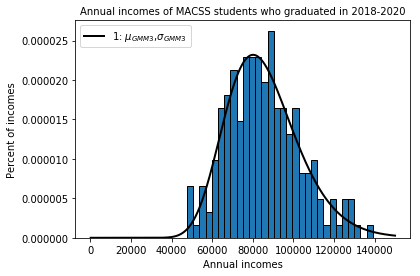

In [28]:
num_bins = 30
plt.hist(df['income'], num_bins, normed=True, edgecolor='k')
plt.title('Annual incomes of MACSS students who graduated in 2018-2020', fontsize=10)
plt.xlabel('Annual incomes')
plt.ylabel('Percent of incomes')

# Plot the estimated GMM PDF using three moments with identity matrix
plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1_3, sig_GMM1_3, 0.0, 150000),
         linewidth=2, color='k', label='1: $\mu_{GMM3}$,$\sigma_{GMM3}$')
plt.legend(loc='upper left')


#### (e) Perform the two-step GMM estimator

In [29]:
def get_Err_mat3(pts, mu, sigma, cut_lb, cut_ub, simple=False):
   
    R = 3
    N = len(pts)
    Err_mat = np.zeros((R, N))
    pct_1_mod, pct_2_mod, pct_3_mod = \
        model_moments3(mu, sigma, cut_lb, cut_ub)
    if simple:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = pts_in_grp1 - pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = pts_in_grp2 - pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = pts_in_grp3 - pct_3_mod

    else:
        pts_in_grp1 = pts < 75000
        Err_mat[0, :] = (pts_in_grp1 - pct_1_mod) / pct_1_mod
        pts_in_grp2 = (pts >= 75000) & (pts < 100000)
        Err_mat[1, :] = (pts_in_grp2 - pct_2_mod) / pct_2_mod
        pts_in_grp3 = pts >= 100000
        Err_mat[2, :] = (pts_in_grp3 - pct_3_mod) / pct_3_mod
    
    return Err_mat

In [30]:
Err_mat3w = get_Err_mat3(df['income'], mu_GMM1_3, sig_GMM1_3, 0.0, 150000.0, False)
VCV2_3w = (1 / df['income'].shape[0]) * (Err_mat3w @ Err_mat3w.T)
print("VCV2_3:","\n",VCV2_3w)
# We use the pseudo-inverse command here because the VCV matrix is poorly conditioned
W_hat2_3 = lin.pinv(VCV2_3w)
print("W_hat2_3","\n",W_hat2_3)

VCV2_3: 
 [[ 2.33333324 -0.99999997 -1.00000004]
 [-0.99999997  0.99999997 -1.00000005]
 [-1.00000004 -1.00000005  4.00000051]]
W_hat2_3 
 [[ 0.25761774 -0.1495845  -0.01246537]
 [-0.1495845   0.11911357 -0.07340719]
 [-0.01246537 -0.07340719  0.20221605]]


In [31]:
para_init=(mu_GMM1_3, sig_GMM1_3)
gmm_args = (df['income'], 0.0, 150000.0, W_hat2_3)
results_4 = opt.minimize(criterion3, para_init, args=(gmm_args),method='L-BFGS-B')
mu_GMM1_3w, sig_GMM1_3w = results_4.x
print('mu_GMM1_3w=', mu_GMM1_3w, ' sig_GMM1_3w=', sig_GMM1_3w)
err3w = err_vec3(df['income'], mu_GMM1_3w, sig_GMM1_3w, 0.0, 150000.0, False).reshape(3,)

print('Error vector=', err3w)
print('GMM criterion function:',results_4.fun)

mu_GMM1_3w= 11.335681325706041  sig_GMM1_3w= 0.2105984529392122
Error vector= [ 1.93122686e-08  1.37049521e-08 -6.32307821e-08]
GMM criterion function: [[1.00542822e-15]]


In [32]:
mom1_model,mom2_model,mom3_model = model_moments3(mu_GMM1_3, sig_GMM1_3, 0, 150000)
mom1_data, mom2_data,mom3_data = data_moments3(df['income'])
print("three moments of data:",mom1_model,mom2_model,mom3_model )
print("three moments from model:",mom1_data, mom2_data,mom3_data)

three moments of data: 0.3000000057936806 0.500000006852476 0.19999998735384358
three moments from model: 0.3 0.5 0.2


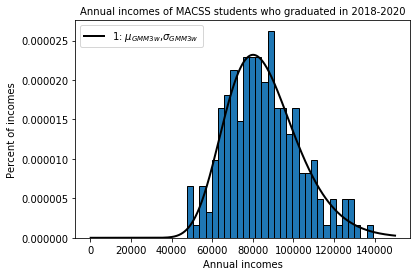

In [33]:
num_bins = 30
plt.hist(df['income'], num_bins, normed=True, edgecolor='k')
plt.title('Annual incomes of MACSS students who graduated in 2018-2020', fontsize=10)
plt.xlabel('Annual incomes')
plt.ylabel('Percent of incomes')

plt.plot(dist_pts, trunc_lognorm_pdf(dist_pts, mu_GMM1_3w, sig_GMM1_3w, 0.0, 150000),
         linewidth=2, color='k', label='1: $\mu_{GMM3w}$,$\sigma_{GMM3w}$')
plt.legend(loc='upper left')


#### (f) Which of the four estimations from parts (b), (c), (d), and (e) fits the data best? Justify your answer.

In [34]:
mu=[mu_GMM1,mu_GMM2,mu_GMM1_3,mu_GMM1_3w]
sig=[sig_GMM1,sig_GMM2,sig_GMM1_3,sig_GMM1_3w]
GMMV=[results.fun,results2.fun,results_3.fun,results_4.fun]

In [35]:
pd.DataFrame({"mu":mu,"sigma":sig,"GMM Fn Value":GMMV}
            ,index=['2 moments+Identity Matrix','2 moments+Weighted Matrix',
                   '3 moments+Identity Matrix','3 moments+Weighted Matrix']).astype(float)

,mu,sigma,GMM Fn Value
2 moments+Identity Matrix,11.333533,0.213862,6.357621e-16
2 moments+Weighted Matrix,11.333533,0.213862,2.635960e-15
3 moments+Identity Matrix,11.335681,0.210598,4.558921e-15
3 moments+Weighted Matrix,11.335681,0.210598,1.005428e-15


The smallest error value is for model (b) for this data, i.e. the model with mean and standard deviation as moments and with the 2-step identity matrix.

#### 2. Linear regression and GMM

#### (a)

In [36]:
df=pd.read_csv("data/sick.txt").astype('float64')

In [37]:
def err_vec(df,b0,b1,b2,b3):
    
    #Model Moments
    yhat=b0+b1*df['age']+b2*df['children']+b3*df['avgtemp_winter']
    
    #Data Moments
    y=df['sick']
    
    err_vec = yhat - y
    
    return err_vec

In [38]:
def criterion(params, *args):
    
    b0,b1,b2,b3 = params
    df, W = args
    err = err_vec(df,b0,b1,b2,b3)
    crit_val = err.T @ W @ err
    
    return crit_val

In [39]:
b0, b1, b2, b3 = 1, 0, 0, 0
params_init = np.array([b0, b1, b2, b3])
W_hat = np.eye(df.shape[0])
gmm_args = (df, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args), tol=1e-14,method='L-BFGS-B')
b0, b1, b2, b3 = results.x

In [40]:
print("Estimate of b0",b0)
print("Estimate of b1",b1)
print("Estimate of b2",b2)
print("Estimate of b3",b3)
print('GMM criterion function:',results.fun)

Estimate of b0 0.2516448637202974
Estimate of b1 0.012933469665776062
Estimate of b2 0.4005009851118556
Estimate of b3 -0.009991708484318558
GMM criterion function: 0.0018212898056107383
